<a href="https://colab.research.google.com/github/Ericdaniel78/repo_prueba/blob/master/EMsimstudies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <img src="https://github.com/JuliaLang/julia-logo-graphics/raw/master/images/julia-logo-color.png" height="100" />     en la nube

El siguiente "notebook" puede ser usado localmente o en la nube Colab de Google al aplicar Ctrl+Enter, o dar clic en el logo de play, en la siguiente celda (tarda de 2 a 3 minutos en instalarse Julia en la sesión de la nube) y posteriormente actualizar la página pulsando Ctrl+R, o F5.

In [ ]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.6.0" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia Distributions Plots"
JULIA_PACKAGES_IF_GPU="CUDA" # or CuArrays for older Julia versions
JULIA_NUM_THREADS=2
#---------------------------------------------------#

if [ -n "$COLAB_GPU" ] && [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  if [ "$COLAB_GPU" = "1" ]; then
      JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia  

  echo ''
  echo "¡Exitosamente instalamos Julia en la nube!"
  echo "Actualice la página (Ctrl+R)."
fi

Installing Julia 1.6.0 on the current Colab Runtime...
2021-05-17 20:46:48 URL:https://storage.googleapis.com/julialang2/bin/linux/x64/1.6/julia-1.6.0-linux-x86_64.tar.gz [112838927/112838927] -> "/tmp/julia.tar.gz" [1]
Installing Julia package IJulia...
Installing Julia package Distributions...
Installing Julia package Plots...
Installing IJulia kernel...
[ Info: Installing julia kernelspec in /root/.local/share/jupyter/kernels/julia-1.6

¡Exitosamente instalamos Julia en la nube!
Actualice la página (Ctrl+R).


# Revisar la instalación
Para cersiorarnos de que la instalación de Julia en la nube haya sido correcta corremos el comando `versioninfo()` que imprime la versión de Julia que estamos utilizando y diversa información del sistema.

In [ ]:
versioninfo()

Julia Version 1.6.0
Commit f9720dc2eb (2021-03-24 12:55 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Xeon(R) CPU @ 2.20GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, broadwell)
Environment:
  JULIA_NUM_THREADS = 2


# Estudio de simulación para algoritmo EM con mezcla de Gaussianas

In [ ]:
# Parámetros verdaderos de la mixtura de Gaussianas
π_vec = [ 0.3, 0.5, 0.2 ]
μ_vec = [ -3.0, 0.0, 3.0 ]
σ_vec = [ 0.3, 1.0, 0.6 ];

In [ ]:
# Cargamos el paquete para declarar distribuciones de probabilidad
using Distributions
# Distribución de la mixtura
D = MixtureModel(Normal[ Normal(μ_vec[1], σ_vec[1]), Normal(μ_vec[2], σ_vec[2]), Normal(μ_vec[3], σ_vec[3])],  π_vec)

MixtureModel{Normal}(K = 3)
components[1] (prior = 0.3000): Normal{Float64}(μ=-3.0, σ=0.3)
components[2] (prior = 0.5000): Normal{Float64}(μ=0.0, σ=1.0)
components[3] (prior = 0.2000): Normal{Float64}(μ=3.0, σ=0.6)


In [ ]:
# Número de datos simulados
n = 300
# Datos simulados
X = rand(D,n);

In [ ]:
# Función para vector de pesos γ en algoritmo EM
function γ(x::Array{Float64,1},π_v::Array{Float64,1},μ_v::Array{Float64,1},σ_v::Array{Float64,1})
    p = length(π_v)
    γ = zeros(Float64,n,p)
    for i in 1:n
        for j in 1:p
            γ[i,j] = π_v[j]*pdf( Normal(μ_v[j],σ_v[j]), x[i]) 
        end
        γ[i,:] = γ[i,:] ./ sum(γ[i,:])
    end
    return γ
end

γ (generic function with 1 method)

In [ ]:
# Número de iteraciones para algoritmo EM
m= 100
# Vectores para guardar estimación EM
μ_EM = zeros(m+1,3)
σ_EM = zeros(m+1,3)
π_EM = zeros(m+1,3)
# Inicialización para algoritmo EM
σ_EM[1,:] = [ std(X) for _ in 1:3]
π_EM[1,:] = [1/3,1/3,1/3]
μ_EM[1,:] = [ X[rand(1:n)] for _ in 1:3];

In [ ]:
# Iteraciones de algoritmo EM
for i in 2:(m+1)
    γ_tmp = γ(X,π_EM[i-1,:],μ_EM[i-1,:],σ_EM[i-1,:])
    for j in 1:3
        n_prop_i_j = sum( γ_tmp[:,j] )
        π_EM[i,j] = n_prop_i_j/n
        μ_EM[i,j] = sum( γ_tmp[:,j] .*  X )/n_prop_i_j
        σ_EM[i,j] = sqrt( sum( γ_tmp[:,j] .*  ( X .- μ_EM[i,j] ).^2.0 )/n_prop_i_j )
    end
end

In [ ]:
# Mixtura generada con última iteración del algoritmo EM
D_EM = MixtureModel(Normal[ Normal(μ_EM[end,1], σ_EM[end,1]), Normal(μ_EM[end,2], σ_EM[end,2]), Normal(μ_EM[end,3], σ_EM[end,3])],  π_EM[end,:])

MixtureModel{Normal}(K = 3)
components[1] (prior = 0.1789): Normal{Float64}(μ=3.0531613514463665, σ=0.5697619039582585)
components[2] (prior = 0.2778): Normal{Float64}(μ=-2.957804171490329, σ=0.2866155779493211)
components[3] (prior = 0.5433): Normal{Float64}(μ=0.24316496312400057, σ=0.9633078472191272)


In [ ]:
# Cargamos paquete para producir imágenes
using Plots

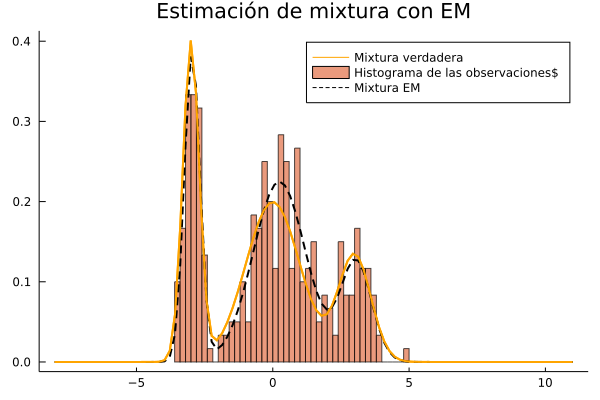

In [ ]:
# Producimos imagen para comparar mixtura EM con la mixtura verdadera
p=plot( LinRange(-8,11,100), pdf.(D,LinRange(-8,11,100)), linewidth=2, color=:orange, label="Mixtura verdadera" )
histogram!( X, nbins=50, normalize=true, grid=false, alpha=0.7, label="Histograma de las observaciones\$")
plot!( LinRange(-8,11,100), pdf.(D_EM,LinRange(-8,11,100)), linestyle=:dash, linewidth=2, color=:black, label="Mixtura EM" )
plot!( LinRange(-8,11,100), pdf.(D,LinRange(-8,11,100)), linewidth=2, color=:orange, label="" )
title!("Estimación de mixtura con EM")

# Estudio de simulación para algoritmo EM con datos censurados por la derecha

In [ ]:
# Función paso M
M(λp) = n/sum( Δ.*Z .+ (1 .- Δ).*( Z .+ 1/λp ) )

M (generic function with 1 method)

In [ ]:
# Número de datos simulados
n = 500
# Datos simulados faltantes de interés
X = rand(Exponential(1.0/1.5), n)
# Tiempos de censura por la derecha
C = rand(Gamma(0.5,2), n)
# Datos observados
Z = [ min( X[i], C[i] ) for i in 1:n ]
# Indicadoras de censura
Δ = X .<= C
# Número de observaciones exactas
sum(Δ)

251

In [ ]:
# Número de iteraciones para algoritmo EM
m = 10000
# Parámetro lambda a estimar a lo largo del algoritmo
λ_run = rand(Uniform(0,10))
for i in 1:m
    λ_run = M(λ_run)
end
# Estimación EM
λ_run

1.3805602432581976